<a href="https://colab.research.google.com/github/jafetsierra/ResNet50_for_SkinCancer_diagnosis/blob/main/SkinCancerProject_v_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SikinCancer medical diagnosis with transfer learning


*   author: Jafet Israel Sierra Lagos
*   contact: jafet.sierra.l@gmail.com




In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 20 16:36:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

conect to drive to get the train 
[link text](https://)

and test data

In [2]:
#First conect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install keras tuner via pip package

In [3]:
! pip install keras-tuner -q

     |████████████████████████████████| 135 kB 5.2 MB/s 


unzip the dataset

In [ ]:
! unzip '/content/drive/MyDrive/Proyectos/SkinCancer/skin_data.zip'

Libraries

In [5]:
#Importamos todas las librerias y paquetes necesarios
import os
import csv
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, InputLayer, Flatten, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Resizing
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow import keras

from tensorflow.keras.utils import image_dataset_from_directory


from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import L2
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

### Ordenamiento de datos y creacion de subcarpetas por cada clase

In [6]:
#Meta data and file index with images ids and diagnosis 
#Archivo con los id's de cada imagen y el diagnostico 
df = pd.read_csv('/content/drive/MyDrive/Proyectos/SkinCancer/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
df['image_name'] = df['image_id'].astype(str) + '.jpg'
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg


#### **The types of diagnosis can be seen below:  \Los tipos de diagnostico se pueden ver abajo**

```
{
    'nv': 'Melanocytic nevi',
    'mel': 'melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
```


In [8]:
#Total de imagenes en el dataset
img_list = list(df['image_id'])
len(img_list)

10015

In [9]:
#Las clases de lesiones que hay en el dataset
df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [10]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

Se observa un desbalance muy fuerte, teniendo clases con apenas unos cientos de imagenes y otras con mas de 1000.

Para resolver el desbalance se emplea una serie de funciones que estan en los archivos de la carpeta utils en el repositorio oficial

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  if __name__ == '__main__':


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fca8e2f0a50>,
      dtype=object)

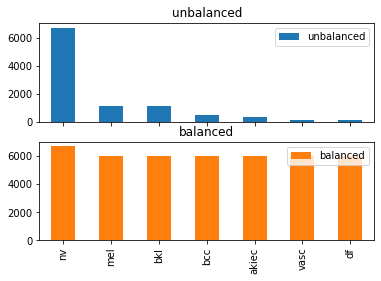

In [11]:
#Despues del oversmapling de las clases con menos imagenes la cantidad de imagenes por clase es la que sigue:
index = ['nv','mel','bkl','bcc','akiec','vasc','df']

balance = {
  'unbalanced': [6705,1113,1099,514,327,142,115],
  'balanced'  : [6705,6001,6001,6001,6001,6001,6001]
}
bl_df = pd.DataFrame.from_dict(balance,orient='columns')
bl_df = bl_df.set_index(pd.Index(index),'i')

bl_df.plot(subplots=True,kind='bar')

## ImageDataGenerator

In [58]:
IMG_SIZE = (224,224)
def get_ImageDataGenerator(path,subset=None,batch_size=32,seed=123,shuffle=True):
  return image_dataset_from_directory(
      path,
      image_size=IMG_SIZE,
      batch_size=batch_size,
      shuffle=shuffle,
      labels='inferred',
      label_mode='categorical',
      seed=seed,
      validation_split=0.20,
      subset=subset
  )
def get_TestImageDataGenerator(path,batch_size=1,seed=123,shuffle=False):
  return image_dataset_from_directory(
      path,
      image_size=IMG_SIZE,
      batch_size=batch_size,
      shuffle=shuffle,
      labels='inferred',
      label_mode='categorical',
      seed=seed,
  )
'''
#preprocessing_function=preprocess_input,
      brightness_range=(0.3,1),
      zoom_range=0.2,
'''

'\n#preprocessing_function=preprocess_input,\n      brightness_range=(0.3,1),\n      zoom_range=0.2,\n'

#### train/val/test

In [59]:
my_directory = '/content/skin_data'
batch = 32

train_ds = get_ImageDataGenerator(my_directory+'/train',subset='training')
val_ds   = get_ImageDataGenerator(my_directory+'/train',subset='validation')
test_ds  = get_TestImageDataGenerator(my_directory+'/test')

Found 34164 files belonging to 7 classes.
Using 27332 files for training.
Found 34164 files belonging to 7 classes.
Using 6832 files for validation.
Found 8547 files belonging to 7 classes.


num of classes and its labels

In [60]:
class_names = train_ds.class_names
num_class   = len(class_names)
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


some of the images on the train dataset

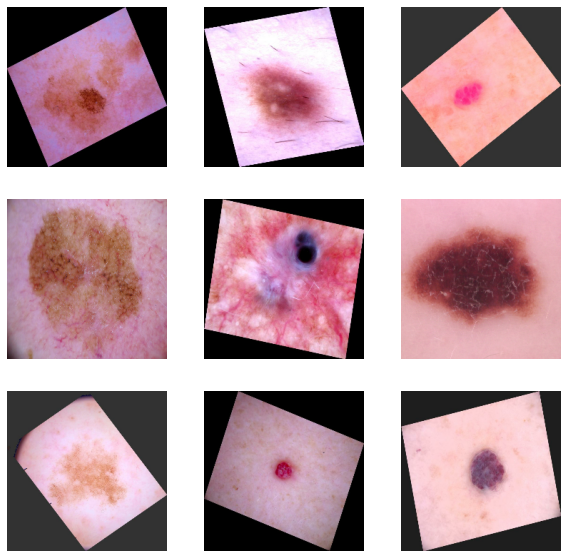

In [61]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

### Data augmentation

#### rotation, flip and zoom
 **bold text**


```
# This is formatted as code
```



In [62]:
data_aug = Sequential([
    Resizing(224,224,interpolation='gaussian'),
    RandomFlip("horizontal"),
    RandomZoom(0.1)
])

shape of the images

In [63]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 7)


## **Base model**

### VGG19

Preprocess function from VGG19
We import and use the preprocess_input that was used in the training of ResNet50V2 model as a new Keras layer

In [ ]:
#import the base model and it's preprocess function
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

#declare the preprocess layer
preprocess_layer = preprocess_input

#VGG19 model trained with Imagenet dataset without the top layers.
IMG_SHAPE = IMG_SIZE+(3,)
base_model = VGG19(
  input_shape=(IMG_SHAPE),
  include_top=False,
  weights='imagenet'
)

#Freeze all the model parameters
base_model.trainable = False
#summary
base_model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

### ResNet50

In [156]:
#import the base model and it's preprocess function
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess

#declare the preprocess layer
preprocess_layer = resnet_preprocess

#VGG19 model trained with Imagenet dataset without the top layers.
IMG_SHAPE = IMG_SIZE+(3,)
base_model = ResNet50V2(
  input_shape=(IMG_SHAPE),
  include_top=False,
  weights='imagenet'
)

#Freeze all the model parameters
base_model.trainable = False
#summary
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

## **keras_tuner**

Search for the best hyperparameters and model architecture

In [ ]:
'''
  for i in range(hp.Int("num_conv2d",1,3)):
    x = Conv2D(
        filters=hp.Int(f"units_{i}",min_value=10,max_value=40,step=10),
        kernel_size=hp.Int(f"kernel_{i}",min_value=2,max_value=4,step=1),
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
  '''

def build_model(hp):
  inputs = Input(shape=(None,None,3))
  x      = data_aug(inputs)
  x      = preprocess_layer(x)
  x      = base_model(x,training=False)
  x      = GlobalAveragePooling2D()(x)
  x      = Dropout(0.3)(x)
#  for i in range(hp.Int("num_dense_layers",1,2,3)):
#    x    = Dense(
#            units=hp.Int(f"units_{i}",min_value=128,max_value=512,step=128),
#            kernel_regularizer='l2',
#            kernel_initializer='he_normal',
#           #bias_initializer='zeros'
#          )(x)
#    x    = BatchNormalization()(x)
#    x    = Activation('relu')(x)
#    x    = Dropout(0.3)(x)#hp.Float(f"dpr_{i}",min_value=0.2,max_value=0.3,step=0.1))(x)
  x      = Dense(128,kernel_regularizer='l2',
            kernel_initializer='he_normal')(x)
  x      = BatchNormalization()(x)
  x      = Activation('relu')(x)
  x      = Dropout(0.2)(x)    
  out    = Dense(num_class,activation='softmax')(x)

  #Learning rate search
  learning_rate = hp.Float("lr",min_value=1e-4, max_value=1e-2,sampling='log')
  
  #we define the model
  model = Model(inputs=inputs,outputs=out)

  #compile the model
  metricas = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
  ]

  model.compile(
    optimizer=Adam(learning_rate),
    loss='categorical_crossentropy',
    metrics=metricas
  )

  return model

BayesianOptimization search for best hyperpameters

In [ ]:
#Best architecture hyperparameters
# 1 dense (128), lr = 5.5e-4
#We define the search as random or bayesian
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_categorical_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="/content/keras_tuner",
    project_name="skin_cancer_tuner"
)
#summary
tuner.search_space_summary()

Search space summary
Default search space size: 1
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


Search

In [ ]:
tuner.search(train_ds, epochs=1,validation_data=val_ds)#,callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)])

Trial 10 Complete [00h 02m 19s]
val_categorical_accuracy: 0.6440281271934509

Best val_categorical_accuracy So Far: 0.6513466238975525
Total elapsed time: 00h 23m 35s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


summary

In [ ]:
tuner.results_summary()

Results summary
Results in /content/keras_tuner/skin_cancer_tuner
Showing 10 best trials
Trial summary
Hyperparameters:
lr: 0.0005472836126493526
Score: 0.6513466238975525
Trial summary
Hyperparameters:
lr: 0.0004581915980831413
Score: 0.6488583087921143
Trial summary
Hyperparameters:
lr: 0.00045735168374408446
Score: 0.6465163826942444
Trial summary
Hyperparameters:
lr: 0.0004813494674440505
Score: 0.6440281271934509
Trial summary
Hyperparameters:
lr: 0.0004326514184761757
Score: 0.6405152082443237
Trial summary
Hyperparameters:
lr: 0.0004315017020802299
Score: 0.6394906044006348
Trial summary
Hyperparameters:
lr: 0.0006147700378968398
Score: 0.6327576041221619
Trial summary
Hyperparameters:
lr: 0.00045279437202180986
Score: 0.6326112151145935
Trial summary
Hyperparameters:
lr: 0.0015209460123717445
Score: 0.6055327653884888
Trial summary
Hyperparameters:
lr: 0.00010000000000000003
Score: 0.5870901346206665


Best so far

In [ ]:
best_hps = tuner.get_best_hyperparameters(5) 
model = build_model(best_hps[0])

Best model architecture summary

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

## **Best model training**

In [157]:
def build_best_model():
  inputs = Input(shape=(None,None,3))
  x      = data_aug(inputs)
  x      = preprocess_layer(x)
  x      = base_model(x,training=False)
  x      = GlobalAveragePooling2D()(x)
  x      = Dropout(0.3)(x)
  x      = Dense(128,kernel_regularizer='l2',
            kernel_initializer='he_normal',
            bias_initializer='zeros')(x)
  x      = BatchNormalization()(x)
  x      = Activation('relu')(x)
  x      = Dropout(0.3)(x)
  out    = Dense(num_class,activation='softmax')(x)

  #Learning rate search
  learning_rate = 1e-4
  
  #we define the model
  model = Model(inputs=inputs,outputs=out)

  #compile the model
  metricas = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
  ]

  model.compile(
    optimizer=Adam(learning_rate),
    loss='categorical_crossentropy',
    metrics=metricas
  )

  return model

In [158]:
best_model = build_best_model()
best_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0   

callbacks and training function

In [160]:
def scheduler(epoch,lr):
  if epoch<6:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

def checkpoint_best():
  path = 'checkpoint_best/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp

def train_model_gen(model,train_gen,val_gen,epochs):
  early_stop = EarlyStopping(patience=1,monitor='val_categorical_accuracy')
  #reduce_lr  = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=2)

  return model.fit(
      train_gen,
      validation_data=val_gen,
      epochs=epochs,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler),checkpoint_best(),early_stop],
      verbose=1
)

### training loop

In [161]:
history = train_model_gen(best_model,train_ds,val_ds,15)

Epoch 1/15
854/855 [============================>.] - ETA: 0s - loss: 3.0537 - categorical_accuracy: 0.4321 - precision_20: 0.6219 - recall_20: 0.2436
Epoch 1: val_categorical_accuracy improved from -inf to 0.58519, saving model to checkpoint_best/checkpoint
855/855 [==============================] - 154s 175ms/step - loss: 3.0537 - categorical_accuracy: 0.4321 - precision_20: 0.6218 - recall_20: 0.2436 - val_loss: 2.1267 - val_categorical_accuracy: 0.5852 - val_precision_20: 0.7873 - val_recall_20: 0.3429 - lr: 1.0000e-04
Epoch 2/15
854/855 [============================>.] - ETA: 0s - loss: 2.0154 - categorical_accuracy: 0.5344 - precision_20: 0.7000 - recall_20: 0.3579
Epoch 2: val_categorical_accuracy improved from 0.58519 to 0.62412, saving model to checkpoint_best/checkpoint
855/855 [==============================] - 147s 172ms/step - loss: 2.0153 - categorical_accuracy: 0.5344 - precision_20: 0.7000 - recall_20: 0.3579 - val_loss: 1.6417 - val_categorical_accuracy: 0.6241 - val_p

In [162]:
best_model.load_weights('/content/checkpoint_best/checkpoint')

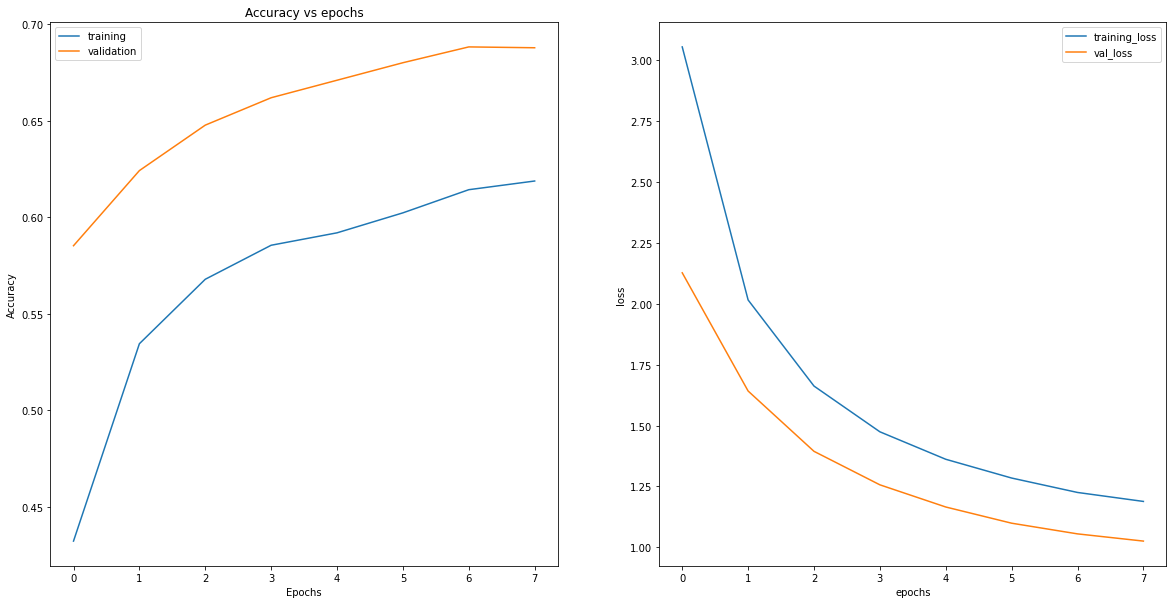

In [163]:
plt.figure(figsize=(20,10))
plt.subplot(121)
try:
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
except KeyError:
  plt.plot(history.history['acc_categorical_'])
  plt.plot(history.history['val_categorical_acc'])
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training_loss','val_loss'])
plt.show()

## Fine Tunning section

total number of layers from the base model

In [164]:
print("Number of layers: ", len(base_model.layers))

Number of layers:  190


we select the point o layer where start to unfreeze

In [165]:
base_model.trainable =True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

metrics and model compile with some of the base model layers unfreezed

In [166]:
early_stop = EarlyStopping(patience=1,monitor='val_categorical_accuracy')
fine_metric = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
  ]
best_model.compile(
    loss='categorical_crossentropy',
    metrics=fine_metric,
    optimizer = Adam(5e-6)
)

best_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0   

callbacks and training function

In [167]:
def checkpoint_best_ft():
  path = 'checkpoint_best_ft/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp
def fine_scheduler(epoch,lr):
  if epoch<14:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

ini_epochs = len(history.epoch)
fine_tun_epochs = 15
total_epochs = ini_epochs + fine_tun_epochs


def train_model_fine_tuning(model,train_gen,val_gen,total_epochs,ini_epoch):
  early_stop = EarlyStopping(patience=1,monitor='val_categorical_accuracy',min_delta=1e-3)
  #reduce_lr  = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=2)
  return model.fit(
      train_ds,
      validation_data=val_ds,
      initial_epoch=ini_epoch,
      epochs=total_epochs,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(fine_scheduler),checkpoint_best_ft(),early_stop],
      verbose=1
)

fine tuning training loop

In [168]:
fine_history = train_model_fine_tuning(best_model,train_ds,val_ds,total_epochs,ini_epochs)

Epoch 9/23
854/855 [============================>.] - ETA: 0s - loss: 1.0221 - categorical_accuracy: 0.6885 - precision_21: 0.7870 - recall_21: 0.5805
Epoch 9: val_categorical_accuracy improved from -inf to 0.76654, saving model to checkpoint_best_ft/checkpoint
855/855 [==============================] - 232s 217ms/step - loss: 1.0221 - categorical_accuracy: 0.6885 - precision_21: 0.7870 - recall_21: 0.5806 - val_loss: 0.8213 - val_categorical_accuracy: 0.7665 - val_precision_21: 0.8458 - val_recall_21: 0.6786 - lr: 5.0000e-06
Epoch 10/23
854/855 [============================>.] - ETA: 0s - loss: 0.8416 - categorical_accuracy: 0.7594 - precision_21: 0.8317 - recall_21: 0.6768
Epoch 10: val_categorical_accuracy improved from 0.76654 to 0.80138, saving model to checkpoint_best_ft/checkpoint
855/855 [==============================] - 185s 216ms/step - loss: 0.8416 - categorical_accuracy: 0.7593 - precision_21: 0.8317 - recall_21: 0.6768 - val_loss: 0.7303 - val_categorical_accuracy: 0.8014

In [169]:
cat_acc     = [*history.history['categorical_accuracy'][:-1],*fine_history.history['categorical_accuracy']]
val_cat_acc = [*history.history['val_categorical_accuracy'][:-1],*fine_history.history['val_categorical_accuracy']]
loss_       = [*history.history['loss'][:-1],*fine_history.history['loss']]
val_loss    = [*history.history['val_loss'][:-1],*fine_history.history['val_loss']]

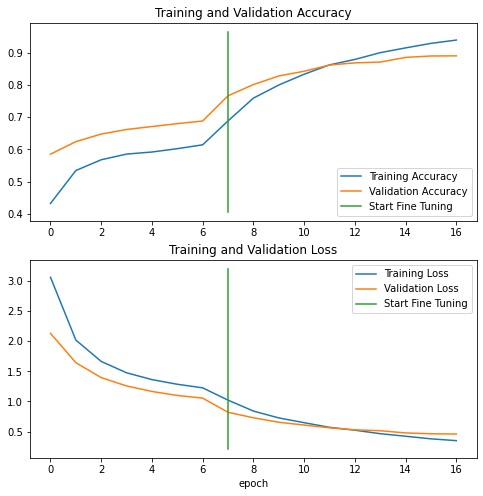

In [170]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(cat_acc, label='Training Accuracy')
plt.plot(val_cat_acc, label='Validation Accuracy')
plt.plot([ini_epochs-1,ini_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([ini_epochs-1,ini_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Model Evaluation on Test set

In [171]:
## loading best weights 
best_model.load_weights('/content/checkpoint_best_ft/checkpoint')

In [172]:
version = '007'
tf.saved_model.save(best_model,f'/content/drive/MyDrive/Proyectos/SkinCancer/model_v_{version}')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/SkinCancer/model_v_007/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/SkinCancer/model_v_007/assets


performance on the test dataset

In [173]:
files = 8547

labels = []
for i in test_ds.take(files):

  labels.append(i[1][0].numpy())


predictions = best_model.predict(test_ds,steps=files)
y_pred      = [np.argmax(x) for x in predictions]
y_true      = [np.argmax(y) for y in labels]

In [174]:
len(y_true)

8547

F1-score

In [175]:
f1_score(y_true,y_pred,average='micro')

0.8903708903708903

In [176]:
f1_score(y_true,y_pred,average='macro')

0.8892766933199356

confussion matrix

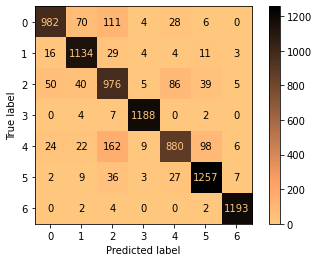

In [177]:
cm   = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='copper_r')
plt.show()

In [ ]:
new_model.save('/content/drive/MyDrive/Proyectos/SkinCancer/SkinCancer_model_v5.h5')

#model.load_weights('/content/drive/MyDrive/Introduction_tensorflow_week_5_assignment/checkpoint_best/checkpoint')
#get_test_accuracy(model, test_data_gray, test_targets)

### predict for a single image and printing the filters for some layers

In [ ]:
import keras.backend as K
from keras.preprocessing.image import img_to_array

In [ ]:
def load_img(path):
  img = tf.keras.utils.load_img(path,target_size=(224,224,3))
  img = img_to_array(img)
  img = np.expand_dims(img,0)
  #img = preprocess_input(img)
  #plt.imshow(img[0])
  return img
def predict_one(tensor):
  prediction = best_model.predict(tensor)
  return prediction


In [ ]:
sample = load_img('/content/ISIC_0024312.jpg')
best_model.predict(sample)

array([[0.9831208 , 0.01687922]], dtype=float32)

In [ ]:
func = K.function([best_model.layers[0].input],best_model.get_layer('vgg19').output)
final_conv_output = func(sample)
final_conv_output.shape

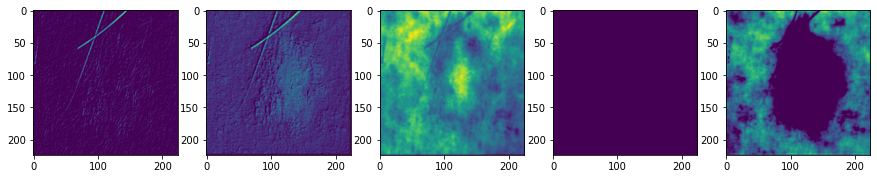

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(15,15))
j = 0
for i in range(final_conv_output.shape[-1]):
  if j<5:
    ax[i].imshow(final_conv_output[0,:,:,i])
  else:
    break
  j+=1
plt.show()

## TFlite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
with open("tflite_model.tflite","wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpdpa43q6u/assets


INFO:tensorflow:Assets written to: /tmp/tmpdpa43q6u/assets


## Aditional functions and code employed


In [ ]:
#this part is only for the procces of re-ordering the data in a local pc, dont run here

#Este fue el proceeso que hice para re-organizar todo el contenido en subcarpetas con cada clase, no ejecutar aqui
#pues las rutas no son iguales y dará un error.
#This part is just for grouping and dividing all the data into separate folders, one for each class
#Adding ".jpg" to all element in the column "image_id" 
df = pd.read_csv('HAM10000_metadata.csv')
df['image_id'] = df['image_id'].astype(str) + '.jpg'

#grouping all the data by dx type
gropued_df = df[['image_id','dx']].groupby(['dx'])
#Saving all the data into groups in a dictionary
types_dic = {}
for key,g in gropued_df:
  types_dic[key] = list(g['image_id'])

#storing the image's file location
files = os.listdir('HAM10000_images')

#Copying files into the new folders

for index,file in enumerate(files):
        keys = str([key for key,value in types_dic.items() if str(file) in value]).replace('[','').replace(']','').replace("'",'')
        shutil.copyfile(f'HAM10000_images/{file}','data/{}/{}'.format(keys,file))


In [ ]:
from IPython.core.pylabtools import figsize
epochs = [0,1,2]

fig, axs = plt.subplots(2,2,figsize=(15,15))
#-----------
subplot1 = 'val_accuracy'
for k, h in history_data.items():
  axs[0,0].plot(epochs,h[subplot1],label=k,linewidth=4.0)
  axs[0,0].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[0,0].set_ylabel(subplot1)
axs[0,0].set_xlabel('Epochs')
axs[0,0].grid(True)
axs[0,0].legend()
axs[0,0].set_title(subplot1)

#-----------
subplot1 = 'accuracy'
for k, h in history_data.items():
  axs[0,1].plot(epochs,h[subplot1],label=k,linewidth=4.0)
  axs[0,1].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[0,1].set_ylabel(subplot1)
axs[0,1].set_xlabel('Epochs')
axs[0,1].grid(True)
axs[0,1].legend()
axs[0,1].set_title(subplot1)

#-----------
subplot1 = 'loss'
for k, h in history_data.items():
  axs[1,1].plot(epochs,h[subplot1],label=k,linewidth=4.0)
  axs[1,1].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[1,1].set_ylabel(subplot1)
axs[1,1].set_xlabel('Epochs')
axs[1,1].grid(True)
axs[1,1].legend()
axs[1,1].set_title(subplot1)

#-----------
subplot1 = 'val_loss'
for k, h in history_data.items():
  axs[1,0].plot(epochs,h[subplot1],label=k,linewidth=4.0)
  axs[1,0].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[1,0].set_ylabel(subplot1)
axs[1,0].set_xlabel('Epochs')
axs[1,0].grid(True)
axs[1,0].legend()
axs[1,0].set_title(subplot1)